In [16]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm

# setting things up:

In [17]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
output_path = path / "Output"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"

In [18]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [19]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [20]:
def plot_hydrograph(ds_combined, ax):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [21]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        axs[i+1].fill_between(ds_combined.time, 
                         ds_combined[var].sel(summary_stat="min").values,
                         ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(var_names[var])
        axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

# Loading files

In [22]:
files = list((output_path/'w2|5_s1e-2|1e-5').glob('*.nc')) + list((output_path/'first_run').glob('*.nc'))

In [23]:
forcing_path = Path.cwd() / "Forcing"
HRU_ids = [path.name[1:8] for path in
           forcing_path.glob("*_lump_cida_forcing_leap.txt")]

In [24]:
len(HRU_ids)

26

In [25]:
HRU_ids = list(set([file.name.split('_')[0] for file in files]))

In [26]:
HRU_ids

['01123000',
 '04296000',
 '01054200',
 '01170100',
 '01137500',
 '01052500',
 '01162500',
 '01139800',
 '01022500',
 '01047000',
 '01057000',
 '01013500',
 '01169000',
 '01142500',
 '01181000',
 '01121000',
 '01031500',
 '01055000',
 '01073000',
 '01078000',
 '01187300',
 '01144000',
 '01139000',
 '01030500',
 '01134500',
 '01118300']

In [27]:
dict_files = {}
for file in files:
    sig = file.name.split('_')[1]
    sig = sig[sig.find("-")+1:]
    sig = f"{float(sig):.0e}"
    w = file.name.split('_')[4].split('-')[1]
    dict_files.update(
                       {f"{file.name.split('_')[0]}_{w}_{sig}" : file}
                        )
sorted_iter = sorted(dict_files.keys())[::-1]

In [28]:
hru_ids = set([file.name.split("_")[0] for file in files]).intersection(set(HRU_ids))
len(hru_ids)

26

In [29]:
list(hru_ids)

['01123000',
 '04296000',
 '01054200',
 '01170100',
 '01137500',
 '01052500',
 '01162500',
 '01139800',
 '01022500',
 '01057000',
 '01047000',
 '01013500',
 '01169000',
 '01142500',
 '01181000',
 '01121000',
 '01031500',
 '01055000',
 '01073000',
 '01078000',
 '01187300',
 '01144000',
 '01139000',
 '01030500',
 '01134500',
 '01118300']

In [30]:
len(sorted_iter)

130

In [31]:
lst_ds = []
for key in sorted_iter:
    ds = xr.open_dataset(dict_files[key])
    lst_ds.append(ds)

In [32]:
df = pd.DataFrame(columns=["NSE_mean","NSE_mean_log", "sigma_p_Sf","sigma_w"])
for index, ds_combined in enumerate(lst_ds):
    uid = sorted_iter[index]
    df.loc[uid, 'NSE_mean'] = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'NSE_mean_log'] = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'sigma_p_Sf'] = ds_combined.attrs["sigma_p_Sf"]
    df.loc[uid, 'sigma_w'] = ds_combined.attrs["sigma_w"]

In [33]:
df_count = df[['sigma_p_Sf','sigma_w','NSE_mean','NSE_mean_log']].groupby(['sigma_p_Sf','sigma_w']).count()
df_count

NSE_mean  NSE_mean_log
sigma_p_Sf sigma_w                        
0.00001    2.0            26            26
           5.0            26            26
0.00010    3.5            26            26
0.00100    2.0            26            26
           5.0            26            26

In [34]:
df = df.sort_values('NSE_mean',ascending=False)
df.head(8)

NSE_mean NSE_mean_log sigma_p_Sf sigma_w
01162500_2_1e-05    0.675692     0.515371    0.00001       2
01022500_2_1e-03    0.645867     0.700359      0.001       2
01022500_2_1e-05    0.643932      0.60959    0.00001       2
01013500_2_1e-03    0.642295    -0.030234      0.001       2
01073000_2_1e-03    0.637625     0.724063      0.001       2
01022500_3.5_1e-04  0.632546      0.66946     0.0001     3.5
01073000_2_1e-05     0.62716     0.608719    0.00001       2
01013500_3.5_1e-04  0.614751     0.001084     0.0001     3.5

In [35]:
df.sort_values('NSE_mean_log',ascending=True).head(3)

NSE_mean NSE_mean_log sigma_p_Sf sigma_w
01137500_2_1e-05 -0.009029    -2.013094    0.00001       2
01052500_5_1e-03 -0.095158    -0.877179      0.001       5
01052500_5_1e-05 -0.050926    -0.859024    0.00001       5

In [36]:
df['HRU_id'] = df.apply(lambda x: x.name.split('_')[0],axis=1)
df['weights'] = df.apply(lambda x: str(df.index[0].split("_")[1]) + "_" +  str(df.index[0].split("_")[2]),axis=1)

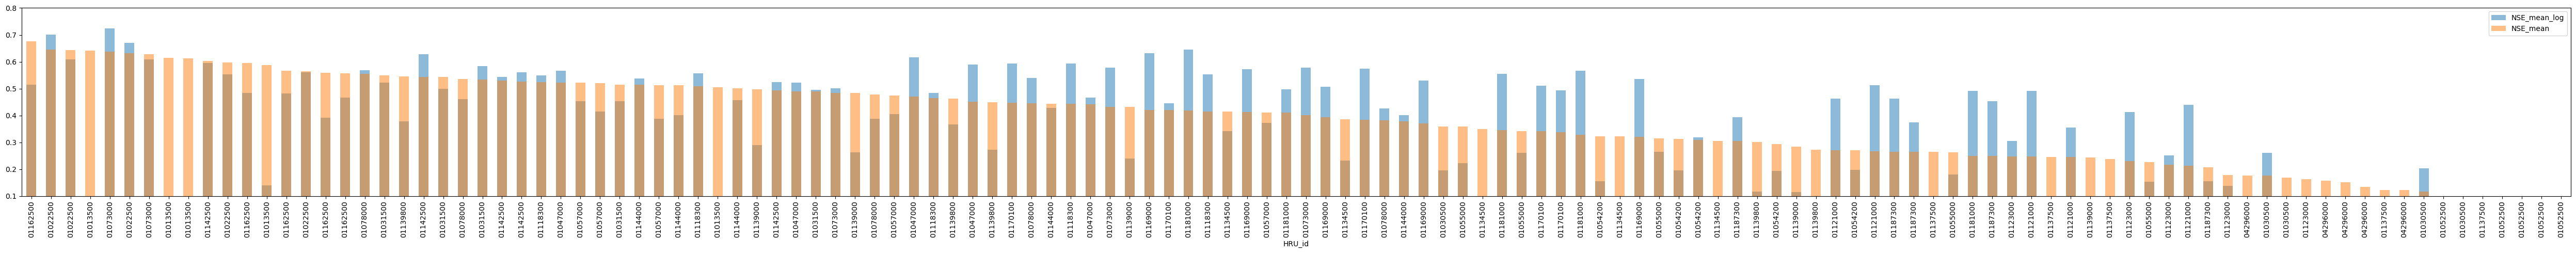

In [37]:
fig, ax = plt.subplots(1,1, sharey=True,figsize=(50,5))
ax=[ax]
df.plot.bar('HRU_id','NSE_mean_log',ax=ax[0],color="C0",alpha=0.5)#lw=0, marker='.',ax=ax[0])
df.plot.bar('HRU_id','NSE_mean',ax=ax[0],color="C1",alpha=0.5) #lw=0, marker='.',ax=ax[0])


# df.plot('sigma_p_Sf','NSE_mean',lw=0, marker='.',ax=ax[1])
# df.plot('sigma_p_Sf','NSE_mean_log',lw=0, marker='.',ax=ax[1])
# ax[0].invert_xaxis()
ax[0].set_ylim(0.1,0.8)
# ax[1].set_xscale('log')
fig.tight_layout()
# ax[0].set_xlim((0,5))
# fig.savefig(figure_path / f'vary_catchments_nse_s.png', bbox_inches="tight",dpi=400)

In [38]:
df.describe(include="all")

NSE_mean  NSE_mean_log  sigma_p_Sf  sigma_w    HRU_id  weights
count   130.000000    130.000000   130.00000      130       130      130
unique  130.000000    130.000000     3.00000        3        26        1
top       0.675692      0.515371     0.00001        2  01162500  2_1e-05
freq      1.000000      1.000000    52.00000       52         5      130

In [39]:
df[df['NSE_mean']>0].agg(
    {

        "NSE_mean": ["min", "max", "median", "skew"],

        "NSE_mean_log": ["min", "max", "median", "mean"],

    }

)

NSE_mean  NSE_mean_log
min     0.027283     -0.472550
max     0.675692      0.724063
median  0.412160      0.425799
skew   -0.227106           NaN
mean         NaN      0.337759

In [40]:
df[['sigma_p_Sf','NSE_mean_log','NSE_mean']].groupby('sigma_p_Sf').mean()

NSE_mean_log  NSE_mean
sigma_p_Sf                       
0.00001        0.255605  0.369007
0.00010        0.301474  0.399842
0.00100        0.304311  0.373462

In [41]:
df[['sigma_w','NSE_mean_log','NSE_mean']].groupby('sigma_w').mean()

NSE_mean_log  NSE_mean
sigma_w                       
2.0         0.278512  0.396576
3.5         0.301474  0.399842
5.0         0.281405  0.345893

In [43]:
summary = df[['sigma_p_Sf','sigma_w','NSE_mean','NSE_mean_log']].groupby(['sigma_p_Sf','sigma_w']).mean()
summary = summary.sort_index(level=1)

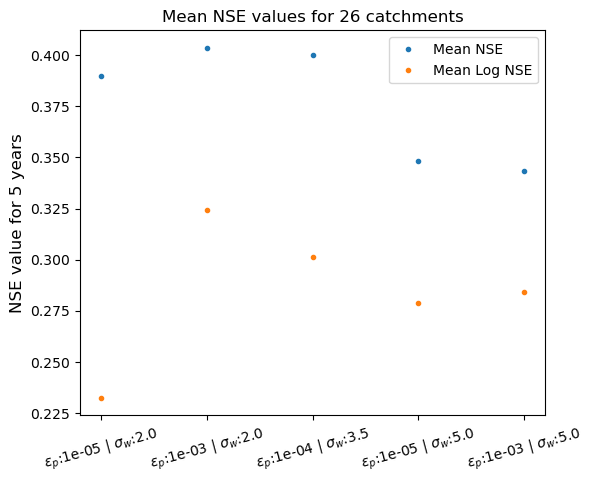

In [44]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
summary.plot(ax=ax,lw=0,marker='.')
ax.set_title("Mean NSE values for 26 catchments")
# ax.set_xlabel("Standard deviation factor of pertubation ($\epsilon_p$) \nand weight ($\sigma_w$) distribution",fontsize='large')
ax.set_xlabel(None)
ax.set_ylabel("NSE value for 5 years",fontsize='large')
ax.set_xticks(range(len(summary)))
ax.set_xticklabels(["$\epsilon_p$:%.e | $\sigma_w$:%s" % item for item in summary.index.tolist()], rotation=15);
# https://stackoverflow.com/questions/21281322/how-to-plot-a-pandas-multiindex-dataframe-with-all-xticks

handels, labels =  ax.get_legend_handles_labels() 
ax.legend(handels, ["Mean NSE", "Mean Log NSE"]);

fig.savefig(figure_path / f'NSE_comparison_26_catchments_1d.png', bbox_inches="tight",dpi=400)

In [45]:
plot_summary = summary.reset_index(level=[0,1])
plot_summary = plot_summary.dropna()
plot_summary = plot_summary[plot_summary['NSE_mean'] > 0]
plot_summary = plot_summary[plot_summary['sigma_p_Sf']<0.1]

In [46]:
best = plot_summary[(plot_summary['sigma_p_Sf' ]==0.001) & (plot_summary['sigma_w' ]==2)]
best

sigma_p_Sf  sigma_w  NSE_mean NSE_mean_log
1       0.001      2.0  0.403591     0.324479

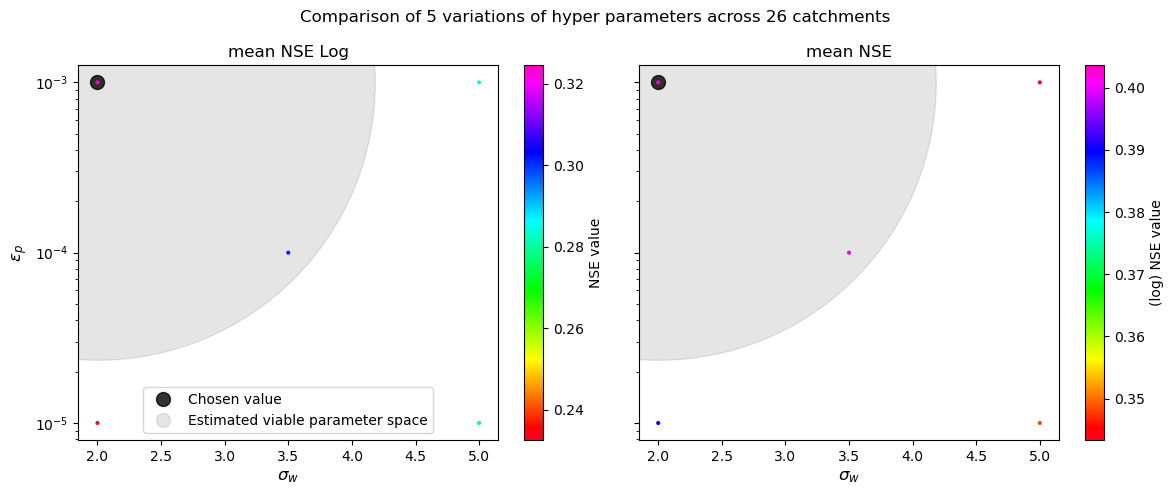

In [48]:
dummy_fig, dummy_ax = plt.subplots(1,1)
dummy_ax.plot(0,0, marker="o",lw=0,ms=10,color="grey",zorder=-10,alpha=0.2, label="optimal value")
handles_other, labels = dummy_ax.get_legend_handles_labels()
plt.close(dummy_fig)

fig, ax = plt.subplots(1,2, sharey=True,figsize=(12,5))
fig.suptitle("Comparison of 5 variations of hyper parameters across 26 catchments")
cb0 = ax[0].scatter(plot_summary['sigma_w'], plot_summary['sigma_p_Sf'], c=plot_summary['NSE_mean_log'], cmap=cm.gist_rainbow, marker='.',s=15)
ax[0].set_title('mean NSE Log')
ax[1].set_title('mean NSE')
cb1 = ax[1].scatter(plot_summary['sigma_w'], plot_summary['sigma_p_Sf'], c=plot_summary['NSE_mean'], cmap=cm.gist_rainbow, marker='.',s=15)
for axs in ax:
    axs.set_xlabel('$\sigma_w$',fontsize="large")
    axs.plot(best['sigma_w'],best['sigma_p_Sf'], marker="o",lw=0,ms=10,color="k",zorder=-10,alpha=0.8, label="Chosen value")
    axs.plot(best['sigma_w'],best['sigma_p_Sf'], marker="o",lw=0,ms=400,color="grey",zorder=-20,alpha=0.2, label="Estimated viable parameter space")
    # axs.plot(best['sigma_w'],best['sigma_p_Sf'], marker="o",lw=0,ms=2000,color="grey",zorder=-20,alpha=0.5, label="estimated viable parameter space")
ax[0].set_yscale('log')
ax[0].set_ylabel('$\epsilon_p$',fontsize="large")
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:1] + handles_other,labels[:2])

plt.colorbar(cb0,label="NSE value");
plt.colorbar(cb1,label="(log) NSE value");

fig.tight_layout()

fig.savefig(figure_path / f'NSE_comparison_26_catchments_2d.png', bbox_inches="tight",dpi=400)

(0.0, 1.0)

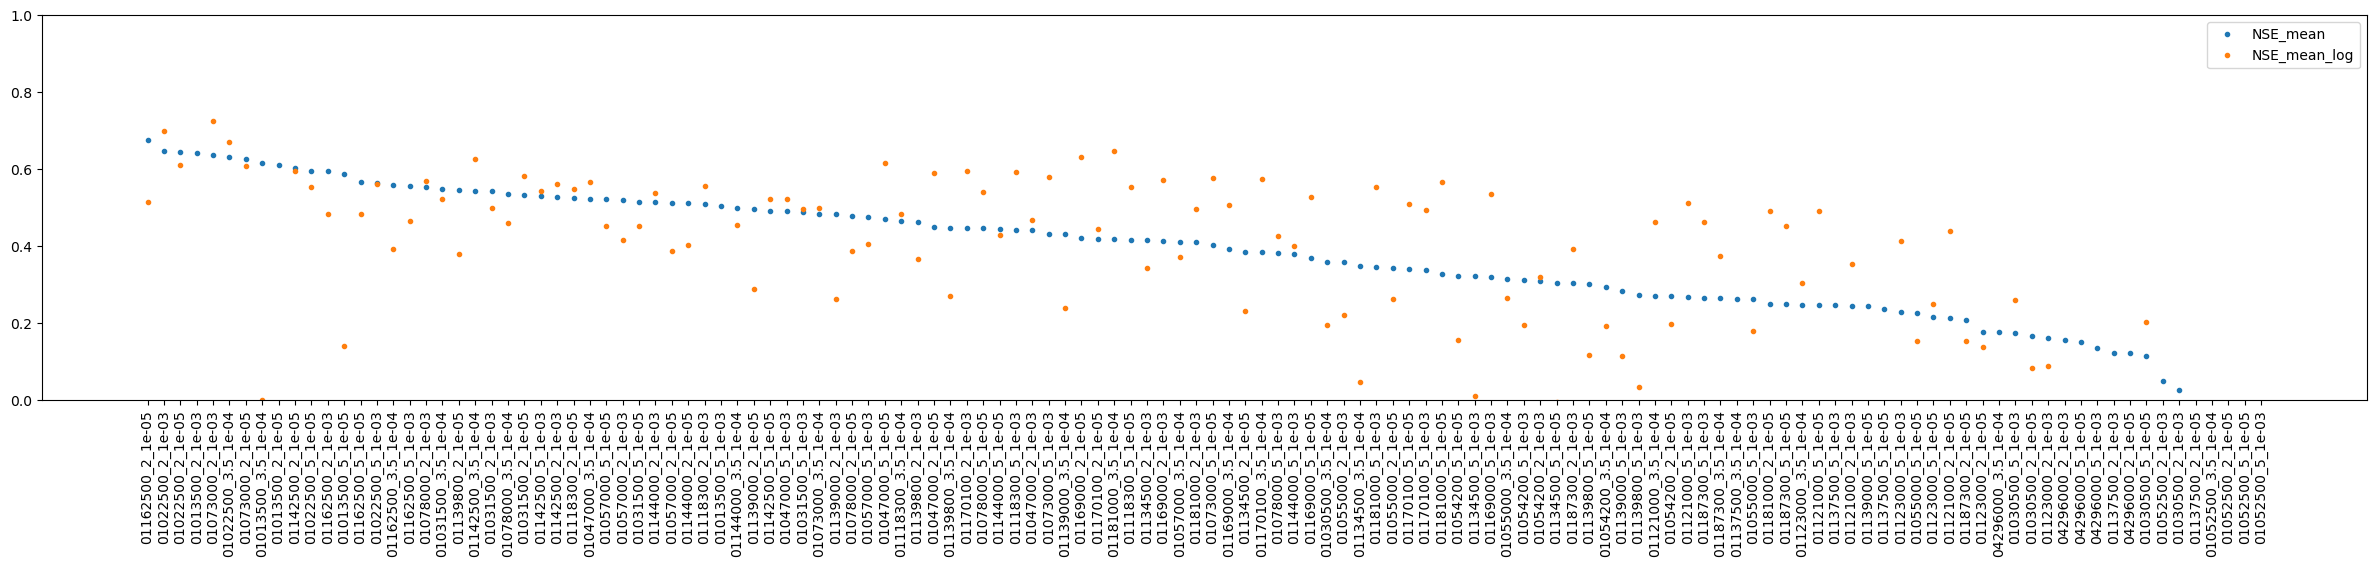

In [49]:
selection_df = df[(df['sigma_p_Sf'] != 0.1)]
fig,ax = plt.subplots(1,1,figsize=(30,5))
selection_df[['NSE_mean','NSE_mean_log']].plot(lw=0,marker='.',ax=ax)
ax.set_xticks(range(len(selection_df)))
ax.set_xticklabels(selection_df.index,rotation=90);
ax.set_ylim(0,1)

(0.0, 1.0)

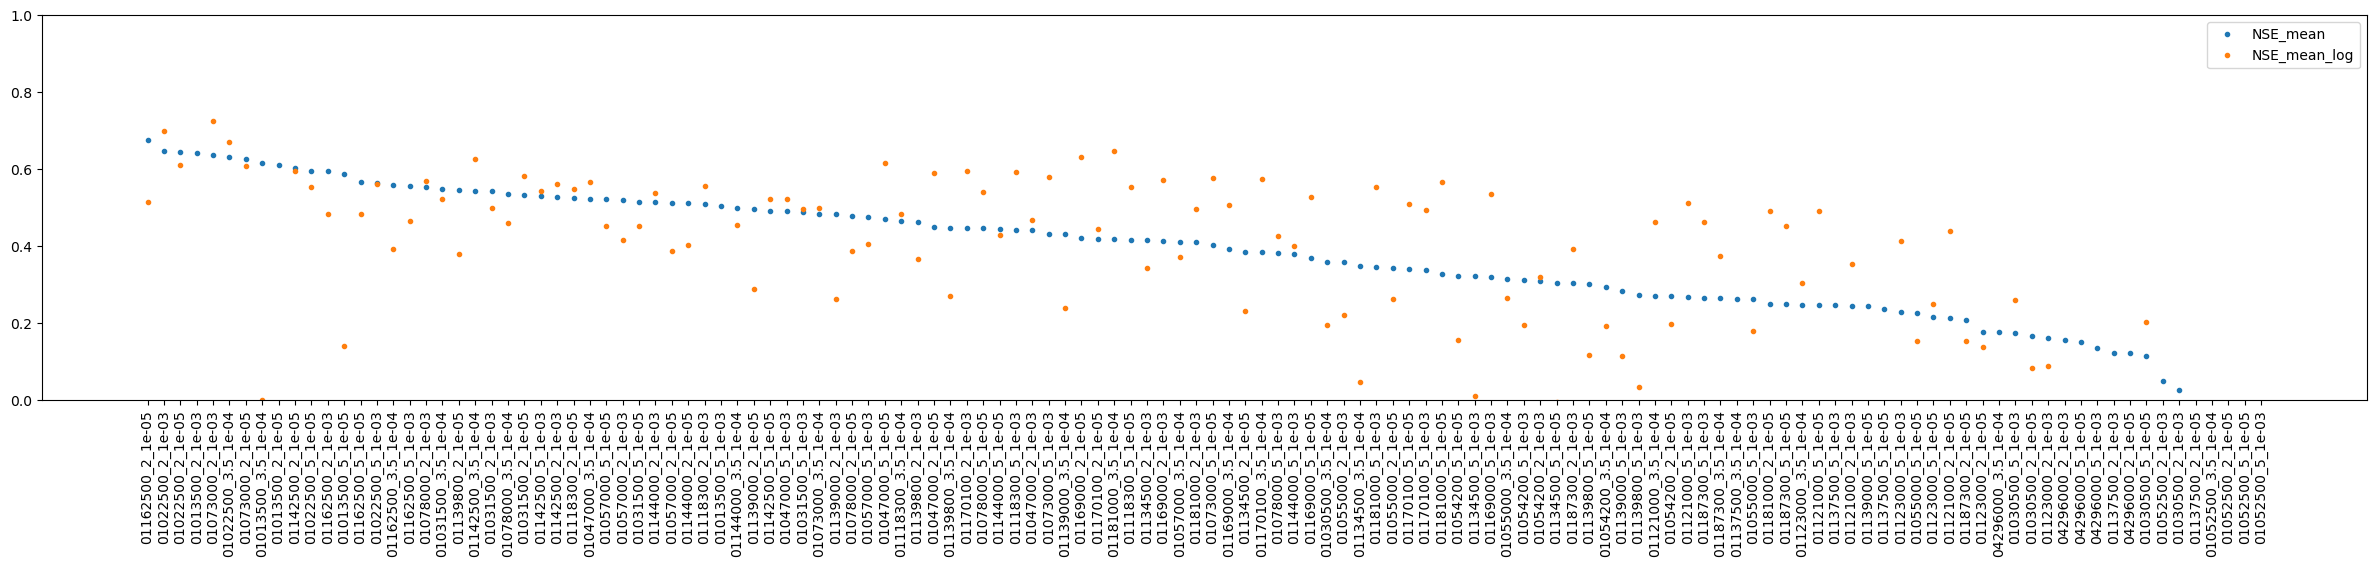

In [52]:
selection_df = df[(df['sigma_p_Sf'] != 0.1)]
fig,ax = plt.subplots(1,1,figsize=(30,5))
selection_df[['NSE_mean','NSE_mean_log']].plot(lw=0,marker='.',ax=ax)
ax.set_xticks(range(len(selection_df)))
ax.set_xticklabels(selection_df.index,rotation=90);
ax.set_ylim(0,1)

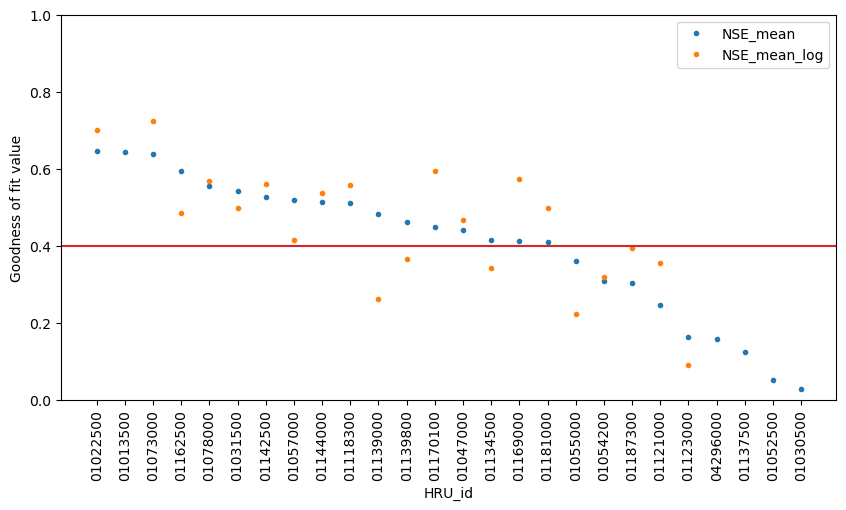

In [59]:
selection_df = df[(df['sigma_p_Sf'] == 0.001) & (df['sigma_w'] == 2)]
fig,ax = plt.subplots(1,1,figsize=(10,5))

selection_df = selection_df.set_index('HRU_id')
selection_df[['NSE_mean','NSE_mean_log']].plot(lw=0,marker='.',ax=ax)
ax.set_xticks(range(len(selection_df)))
ax.set_xticklabels(selection_df.index,rotation=90);
ax.set_ylim(0,1)
ax.axhline(0.4,color="C3");
ax.set_ylabel("Goodness of fit value");

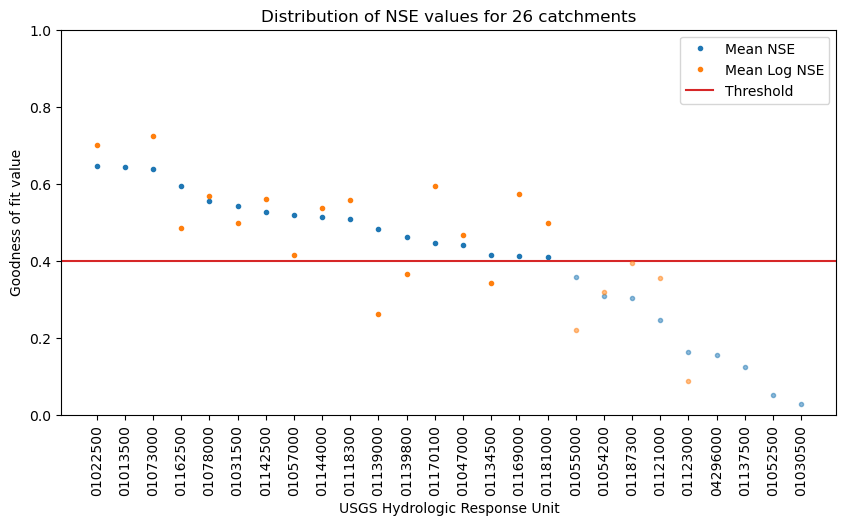

In [88]:

selection_df = df[(df['sigma_p_Sf'] == 0.001) & (df['sigma_w'] == 2)].copy()
selection_df = selection_df.set_index('HRU_id')
selection_df['dropped'] = selection_df.apply(lambda x: np.nan if x.NSE_mean < 0.4 and x.NSE_mean_log < 0.4 else 0, axis=1)

selection_df_dopped = df[(df['sigma_p_Sf'] == 0.001) & (df['sigma_w'] == 2)].copy()
selection_df_dopped = selection_df_dopped.set_index('HRU_id')
selection_df_dopped['NSE_mean'] = selection_df_dopped.apply(lambda x: x.NSE_mean if x.NSE_mean < 0.4 and x.NSE_mean_log < 0.4 else np.nan, axis=1)
selection_df_dopped['NSE_mean_log'] = selection_df_dopped.apply(lambda x: x.NSE_mean_log if x.NSE_mean < 0.4 and x.NSE_mean_log < 0.4 else np.nan, axis=1)

selected_df = selection_df.dropna()
# selection_df_dopped = selection_df_dopped.dropna()


fig,ax = plt.subplots(1,1,figsize=(10,5))
selected_df[['NSE_mean','NSE_mean_log']].plot(lw=0,marker='.',ax=ax)
ax.axhline(0.4,color="C3",label="Threshold")

selection_df_dopped[['NSE_mean']].plot(lw=0,marker='.',ax=ax,color="C0",alpha=0.5)
selection_df_dopped[['NSE_mean_log']].plot(lw=0,marker='.',ax=ax,color="C1",alpha=0.5)
ax.set_xticks(range(len(selection_df)))
ax.set_xticklabels(selection_df.index,rotation=90);
ax.set_ylim(0,1)
ax.set_ylabel("Goodness of fit value")
ax.set_xlabel("USGS Hydrologic Response Unit")


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3],["Mean NSE", "Mean Log NSE","Threshold"])
title = "Distribution of NSE values for 26 catchments"
ax.set_title(title);

fig.savefig(figure_path / (title + 'png'), bbox_inches="tight",dpi=400)

In [213]:
selected_df

NSE_mean NSE_mean_log sigma_p_Sf sigma_w    HRU_id  weights  \
01022500_2_1e-03  0.645867     0.700359      0.001       2  01022500  2_1e-05   
01013500_2_1e-03  0.642295    -0.030234      0.001       2  01013500  2_1e-05   
01073000_2_1e-03  0.637625     0.724063      0.001       2  01073000  2_1e-05   
01162500_2_1e-03  0.594698      0.48452      0.001       2  01162500  2_1e-05   
01078000_2_1e-03  0.554328     0.568478      0.001       2  01078000  2_1e-05   
01031500_2_1e-03  0.542902     0.498884      0.001       2  01031500  2_1e-05   
01142500_2_1e-03  0.526547     0.561212      0.001       2  01142500  2_1e-05   
01057000_2_1e-03  0.519463     0.415454      0.001       2  01057000  2_1e-05   
01144000_2_1e-03  0.513726     0.537219      0.001       2  01144000  2_1e-05   
01118300_2_1e-03  0.509386     0.556945      0.001       2  01118300  2_1e-05   
01139000_2_1e-03  0.483208     0.262523      0.001       2  01139000  2_1e-05   
01139800_2_1e-03  0.462036     0.366095      0.001       2  01139800  2_1e-05   
01170100_2_1e-03  0.447196     0.594156      0.001       2  01170100  2_1e-05   
01047000_2_1e-03  0.441093     0.467348      0.001       2  01047000  2_1e-05   
01134500_2_1e-03  0.414798     0.342082      0.001       2  01134500  2_1e-05   
01169000_2_1e-03   0.41216     0.572489      0.001       2  01169000  2_1e-05   
01181000_2_1e-03  0.410529     0.497388      0.001       2  01181000  2_1e-05   

                  dropped  
01022500_2_1e-03      0.0  
01013500_2_1e-03      0.0  
01073000_2_1e-03      0.0  
01162500_2_1e-03      0.0  
01078000_2_1e-03      0.0  
01031500_2_1e-03      0.0  
01142500_2_1e-03      0.0  
01057000_2_1e-03      0.0  
01144000_2_1e-03      0.0  
01118300_2_1e-03      0.0  
01139000_2_1e-03      0.0  
01139800_2_1e-03      0.0  
01170100_2_1e-03      0.0  
01047000_2_1e-03      0.0  
01134500_2_1e-03      0.0  
01169000_2_1e-03      0.0  
01181000_2_1e-03      0.0

In [224]:
paths_analysed_ds = []
for key in selected_df.index:
    paths_analysed_ds.append(dict_files[key])

In [225]:
paths_analysed_ds

[PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01022500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 14_02.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01013500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 12_47.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01073000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 00_07.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01162500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 12_45.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e

#### best 25

In [216]:
best_25 = df.sort_values('NSE_mean_log',ascending=False).head(25)
best_25

NSE_mean NSE_mean_log sigma_p_Sf sigma_w    HRU_id  \
01073000_2_1e-03    0.637625     0.724063      0.001       2  01073000   
01022500_2_1e-03    0.645867     0.700359      0.001       2  01022500   
01022500_3.5_1e-04  0.632546      0.66946     0.0001     3.5  01022500   
01181000_3.5_1e-04  0.419153     0.646047     0.0001     3.5  01181000   
01169000_2_1e-05    0.420216     0.631633    0.00001       2  01169000   
01142500_3.5_1e-04  0.543762     0.627071     0.0001     3.5  01142500   
01047000_5_1e-05    0.469649     0.616983    0.00001       5  01047000   
01022500_2_1e-05    0.643932      0.60959    0.00001       2  01022500   
01073000_2_1e-05     0.62716     0.608719    0.00001       2  01073000   
01142500_2_1e-05    0.603198     0.594307    0.00001       2  01142500   
01170100_2_1e-03    0.447196     0.594156      0.001       2  01170100   
01118300_5_1e-03    0.442696     0.593757      0.001       5  01118300   
01047000_2_1e-05    0.450327     0.588923    0.00001       2  01047000   
01031500_2_1e-05    0.533351     0.583307    0.00001       2  01031500   
01073000_5_1e-03    0.432357     0.578581      0.001       5  01073000   
01073000_5_1e-05    0.401696     0.577422    0.00001       5  01073000   
01170100_3.5_1e-04  0.384098     0.575017     0.0001     3.5  01170100   
01169000_2_1e-03     0.41216     0.572489      0.001       2  01169000   
01078000_2_1e-03    0.554328     0.568478      0.001       2  01078000   
01181000_5_1e-05    0.328431     0.566753    0.00001       5  01181000   
01047000_3.5_1e-04  0.522889     0.565817     0.0001     3.5  01047000   
01022500_5_1e-03     0.56407     0.561323      0.001       5  01022500   
01142500_2_1e-03    0.526547     0.561212      0.001       2  01142500   
01118300_2_1e-03    0.509386     0.556945      0.001       2  01118300   
01181000_5_1e-03    0.346169     0.554651      0.001       5  01181000   

                    weights  
01073000_2_1e-03    2_1e-05  
01022500_2_1e-03    2_1e-05  
01022500_3.5_1e-04  2_1e-05  
01181000_3.5_1e-04  2_1e-05  
01169000_2_1e-05    2_1e-05  
01142500_3.5_1e-04  2_1e-05  
01047000_5_1e-05    2_1e-05  
01022500_2_1e-05    2_1e-05  
01073000_2_1e-05    2_1e-05  
01142500_2_1e-05    2_1e-05  
01170100_2_1e-03    2_1e-05  
01118300_5_1e-03    2_1e-05  
01047000_2_1e-05    2_1e-05  
01031500_2_1e-05    2_1e-05  
01073000_5_1e-03    2_1e-05  
01073000_5_1e-05    2_1e-05  
01170100_3.5_1e-04  2_1e-05  
01169000_2_1e-03    2_1e-05  
01078000_2_1e-03    2_1e-05  
01181000_5_1e-05    2_1e-05  
01047000_3.5_1e-04  2_1e-05  
01022500_5_1e-03    2_1e-05  
01142500_2_1e-03    2_1e-05  
01118300_2_1e-03    2_1e-05  
01181000_5_1e-03    2_1e-05

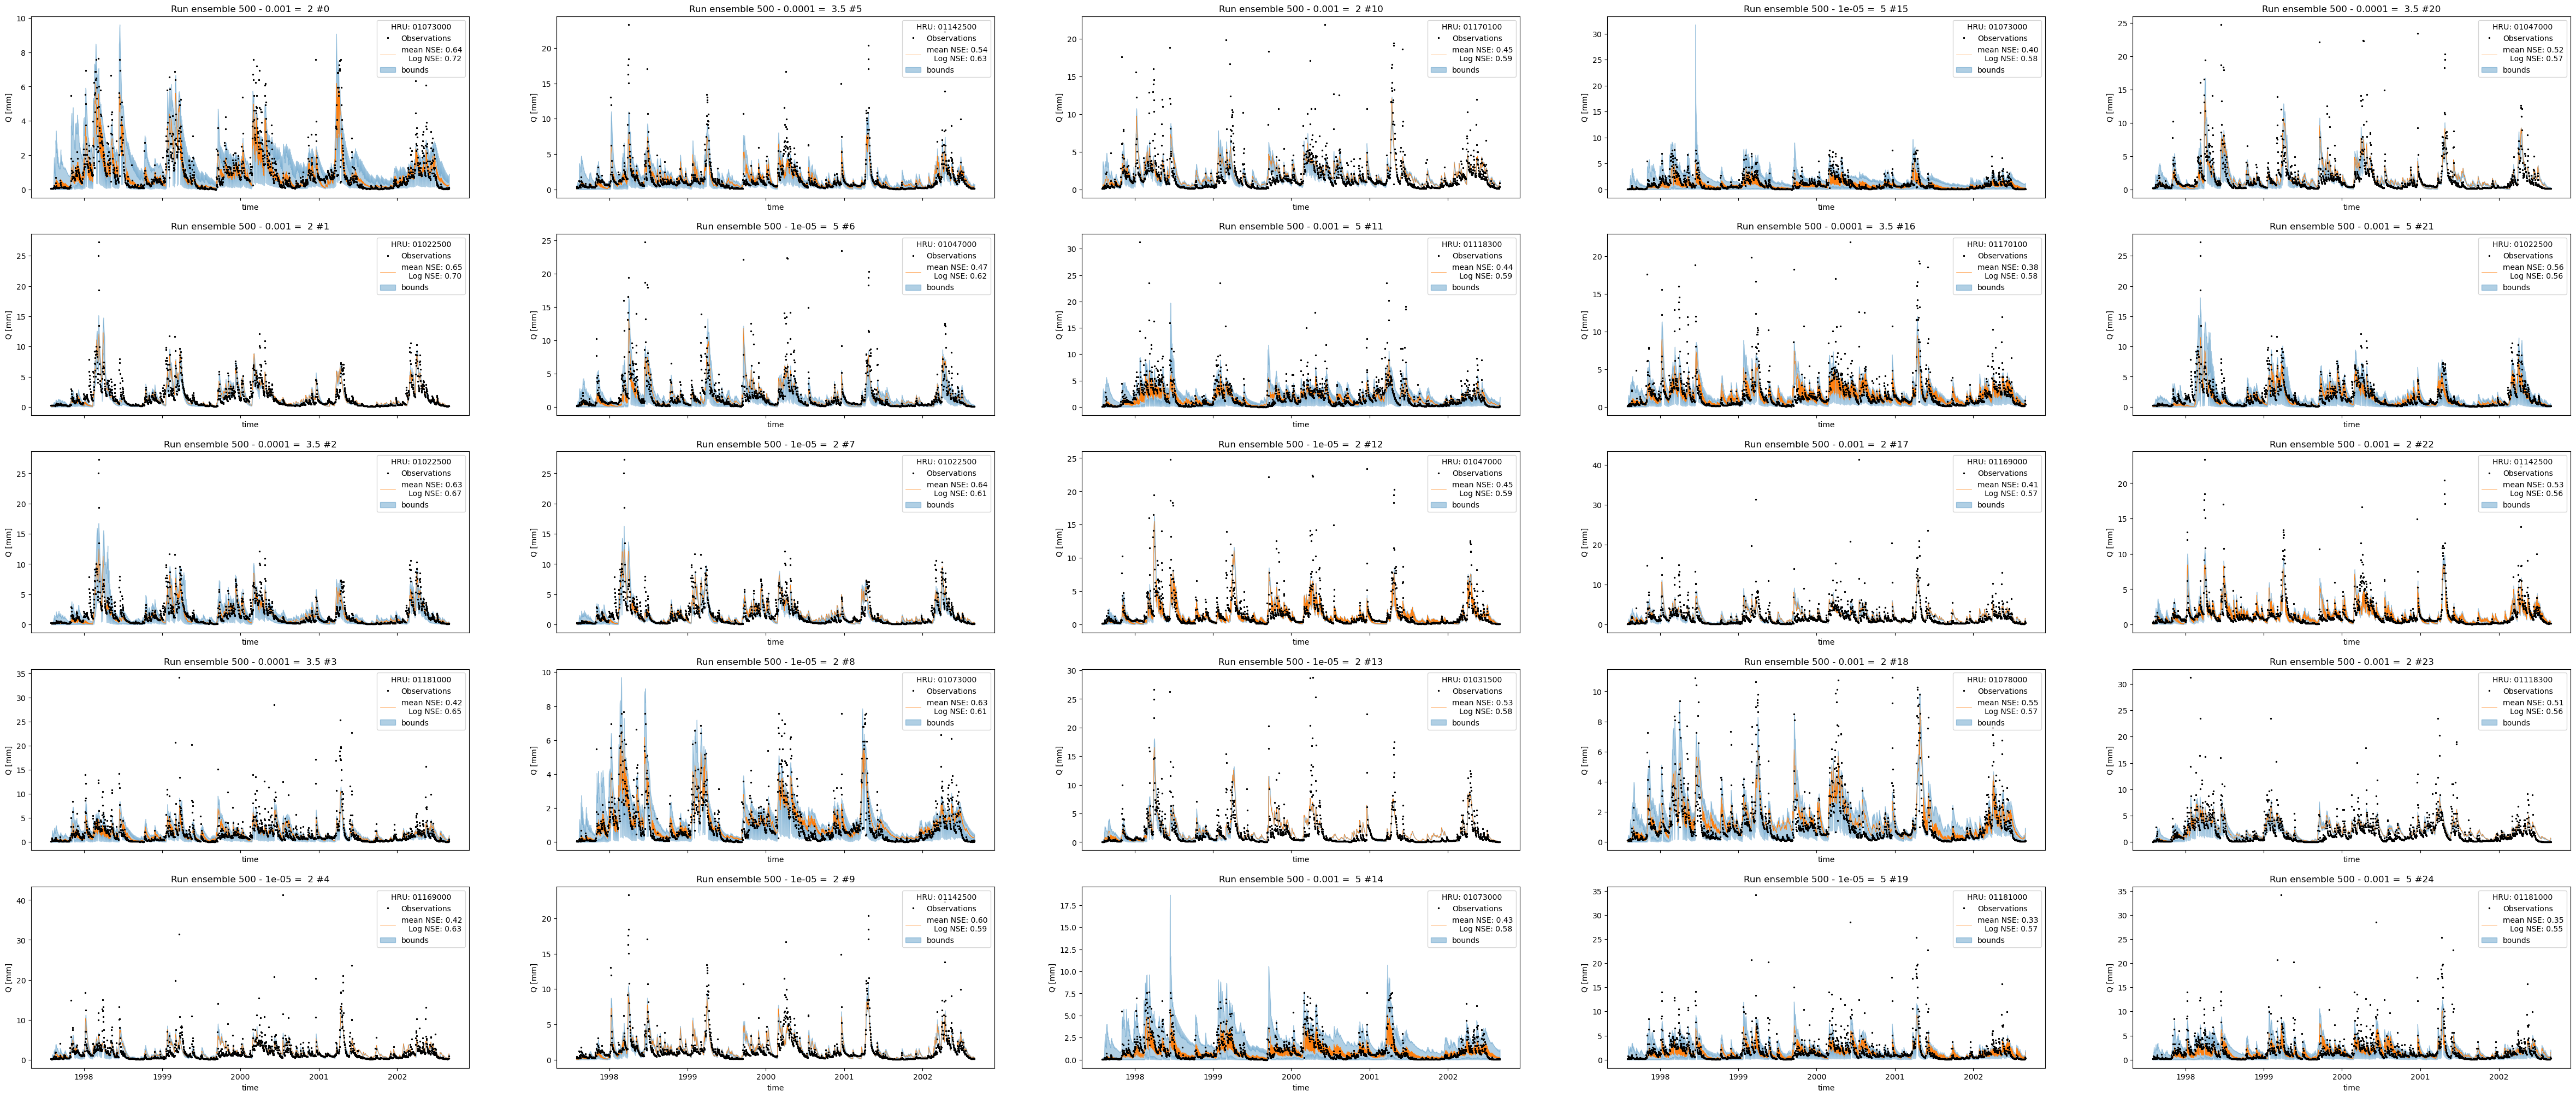

In [217]:
y1, x1   = 5,5
fig, axs_2d = plt.subplots(y1,x1,figsize=(12*x1,5*y1), sharex=True)
j = 0
k = 0
for i in range(0,x1*y1):
    if k >= y1: 
        j += 1
        k = 0
    ax = axs_2d[k, j]
    k += 1

    if i >= len(lst_ds):
        ax.axis('off')
    else:
        ds_combined = lst_ds[sorted_iter.index(best_25.index[i])]
        ax = plot_hydrograph(ds_combined, ax)
        ax.set_title(f'Run ensemble {ds_combined.attrs["n_particles"]} - {ds_combined.attrs["sigma_p_Sf"]} =  {ds_combined.attrs["sigma_w"]} #{i}')
        # if k == 1:
        ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
        # else:
            # ax.legend()

# fig.savefig(figure_path / f'vary_catchments.png', bbox_inches="tight",dpi=400)

### Best 25 w=2,s=1e-3

In [91]:
df_best_2_1e3 = df[df['sigma_w'] == 2]
df_best_2_1e3 = df_best_2_1e3[df_best_2_1e3['sigma_p_Sf']==0.001]
df_best_2_1e3

NSE_mean NSE_mean_log sigma_p_Sf sigma_w    HRU_id  weights
01073000_2_1e-03  0.637625     0.724063      0.001       2  01073000  2_1e-03
01022500_2_1e-03  0.645867     0.700359      0.001       2  01022500  2_1e-03
01170100_2_1e-03  0.447196     0.594156      0.001       2  01170100  2_1e-03
01169000_2_1e-03   0.41216     0.572489      0.001       2  01169000  2_1e-03
01078000_2_1e-03  0.554328     0.568478      0.001       2  01078000  2_1e-03
01142500_2_1e-03  0.526547     0.561212      0.001       2  01142500  2_1e-03
01118300_2_1e-03  0.509386     0.556945      0.001       2  01118300  2_1e-03
01144000_2_1e-03  0.513726     0.537219      0.001       2  01144000  2_1e-03
01031500_2_1e-03  0.542902     0.498884      0.001       2  01031500  2_1e-03
01181000_2_1e-03  0.410529     0.497388      0.001       2  01181000  2_1e-03
01162500_2_1e-03  0.594698      0.48452      0.001       2  01162500  2_1e-03
01047000_2_1e-03  0.441093     0.467348      0.001       2  01047000  2_1e-03
01057000_2_1e-03  0.519463     0.415454      0.001       2  01057000  2_1e-03
01187300_2_1e-03  0.303964     0.393015      0.001       2  01187300  2_1e-03
01139800_2_1e-03  0.462036     0.366095      0.001       2  01139800  2_1e-03
01121000_2_1e-03  0.245427     0.354039      0.001       2  01121000  2_1e-03
01134500_2_1e-03  0.414798     0.342082      0.001       2  01134500  2_1e-03
01054200_2_1e-03  0.308815     0.318619      0.001       2  01054200  2_1e-03
01139000_2_1e-03  0.483208     0.262523      0.001       2  01139000  2_1e-03
01055000_2_1e-03  0.358656     0.221304      0.001       2  01055000  2_1e-03
01123000_2_1e-03   0.16192     0.088864      0.001       2  01123000  2_1e-03
01013500_2_1e-03  0.642295    -0.030234      0.001       2  01013500  2_1e-03
01052500_2_1e-03  0.050164     -0.06317      0.001       2  01052500  2_1e-03
01137500_2_1e-03  0.122946    -0.201515      0.001       2  01137500  2_1e-03
01030500_2_1e-03  0.027283    -0.361689      0.001       2  01030500  2_1e-03
04296000_2_1e-03  0.156342    -0.431979      0.001       2  04296000  2_1e-03

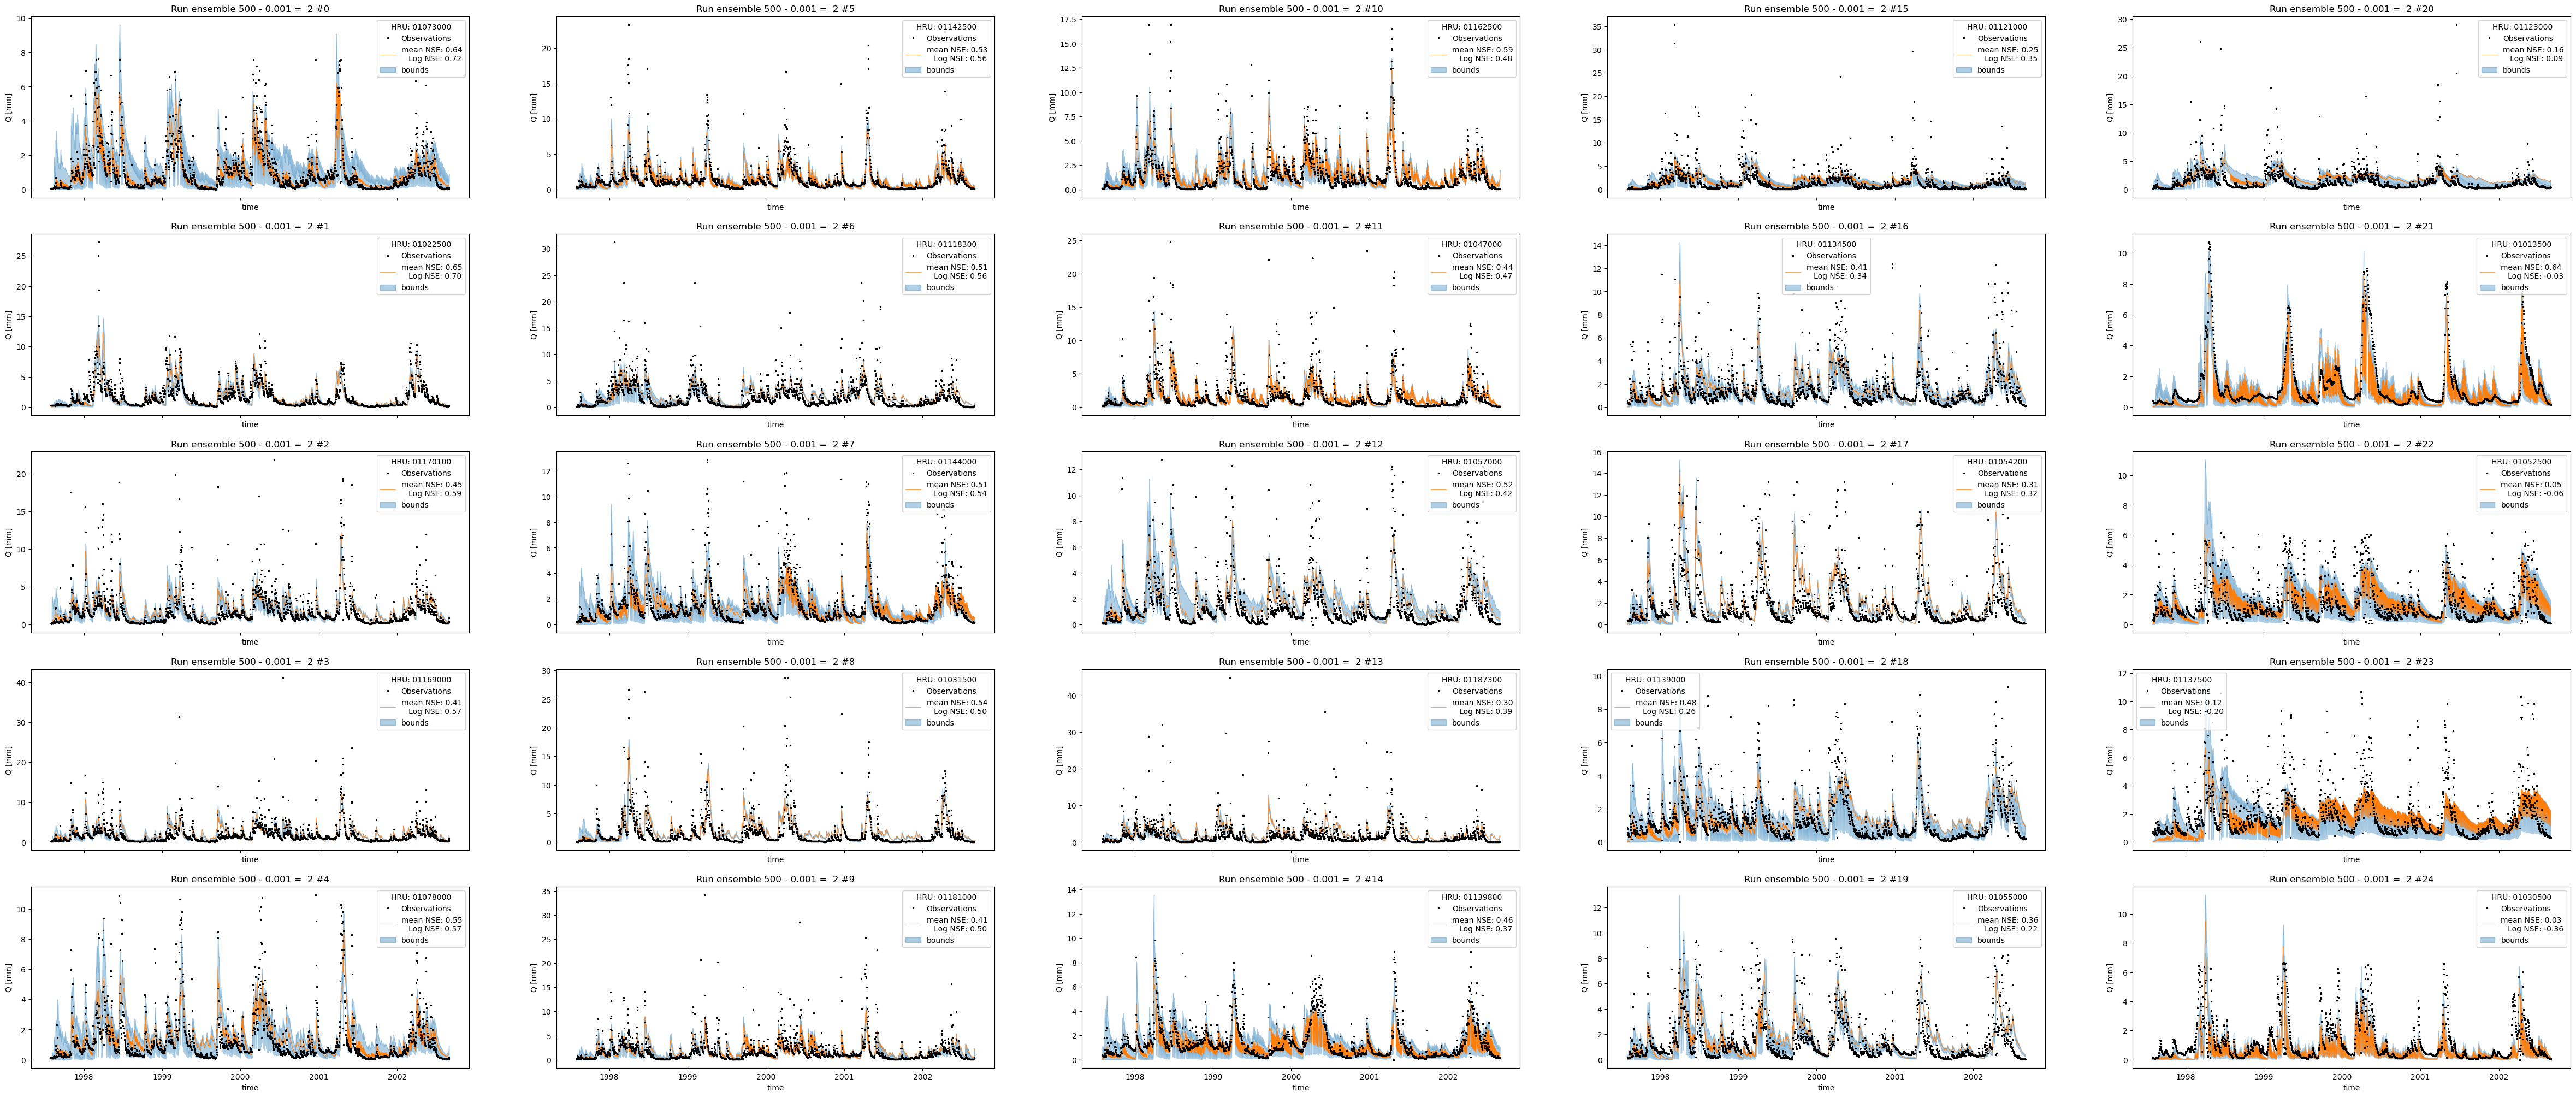

In [92]:
y1, x1   = 5,5
fig, axs_2d = plt.subplots(y1,x1,figsize=(12*x1,5*y1), sharex=True)
j = 0
k = 0
for i in range(0,x1*y1):
    if k >= y1: 
        j += 1
        k = 0
    ax = axs_2d[k, j]
    k += 1

    if i >= len(lst_ds):
        ax.axis('off')
    else:
        ds_combined = lst_ds[sorted_iter.index(df_best_2_1e3.index[i])]
        ax = plot_hydrograph(ds_combined, ax)
        ax.set_title(f'Run ensemble {ds_combined.attrs["n_particles"]} - {ds_combined.attrs["sigma_p_Sf"]} =  {ds_combined.attrs["sigma_w"]} #{i}')
        # if k == 1:
        ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
        # else:
            # ax.legend()

# fig.savefig(figure_path / f'vary_catchments.png', bbox_inches="tight",dpi=400)

# Good example:

In [76]:
i = sorted_iter.index('01073000_2_1e-03')
ds_combined = lst_ds[i]
ds_combined

<xarray.Dataset> Size: 728kB
Dimensions:       (summary_stat: 3, time: 1857)
Coordinates:
  * summary_stat  (summary_stat) <U4 48B 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 15kB 1997-08-01 ... 2002-08-31
Data variables: (12/18)
    Imax          (summary_stat, time) float64 45kB ...
    Ce            (summary_stat, time) float64 45kB ...
    Sumax         (summary_stat, time) float64 45kB ...
    Beta          (summary_stat, time) float64 45kB ...
    Pmax          (summary_stat, time) float64 45kB ...
    Tlag          (summary_stat, time) float64 45kB ...
    ...            ...
    Ss            (summary_stat, time) float64 45kB ...
    Sp            (summary_stat, time) float64 45kB ...
    Q             (summary_stat, time) float64 45kB ...
    Q_obs         (time) float64 15kB 0.06248 0.04999 0.05233 ... 0.1172 0.04686
    Neff          (time) float64 15kB ...
    n_resample    (time) float64 15kB ...
Attributes: (12/13)
    title:              HBV storage & parameter terms data over time for 500 ...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0
    sigma_ps:           0
    sigma_w:            2
    sigma_p_Sf:         0.001
    ...                 ...
    n_particles:        500
    HRU_id:             01073000
    p_min_initial:      [1.38271498e+00 2.07225353e-01 9.57184630e+01 6.31605...
    p_max_initial:      [7.29577260e+00 9.15790021e-01 5.94806582e+02 3.89947...
    s_max_initial:      [  4.67111431 329.82576609 111.49470142  26.12225512 ...
    s_min_initial:      [ 0.66224652 52.98945943 10.36909498  1.67897653  8.6...

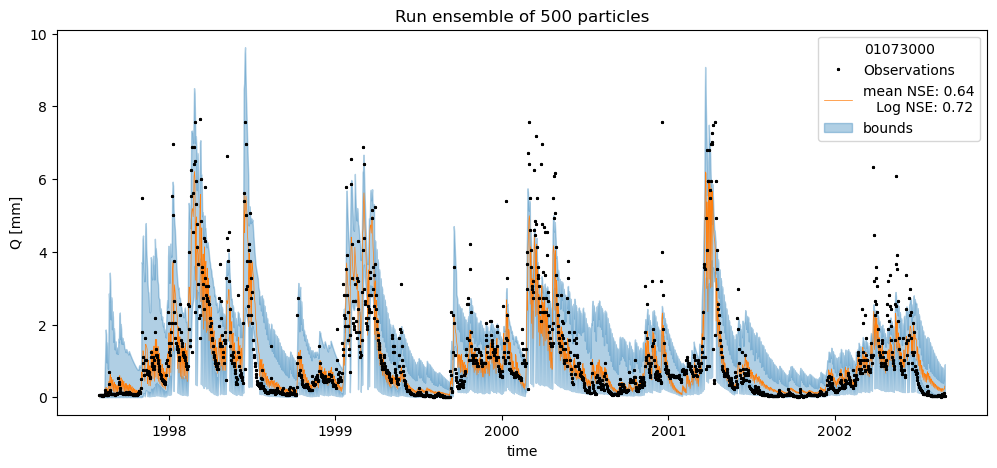

In [78]:
fig, ax = plt.subplots(1,1, figsize=(12,5),sharex=True)
ax = plot_hydrograph(ds_combined, ax)
ax.legend(title=ds_combined.attrs['HRU_id'])
current_time = str(datetime.now())[:-10].replace(":","_")
# fig.savefig(figure_path / f"Ensemble run for {ds_combined.attrs['HRU_id']}_{ds_combined.attrs['n_particles']}_{current_time}.png",bbox_inches="tight", dpi=600)

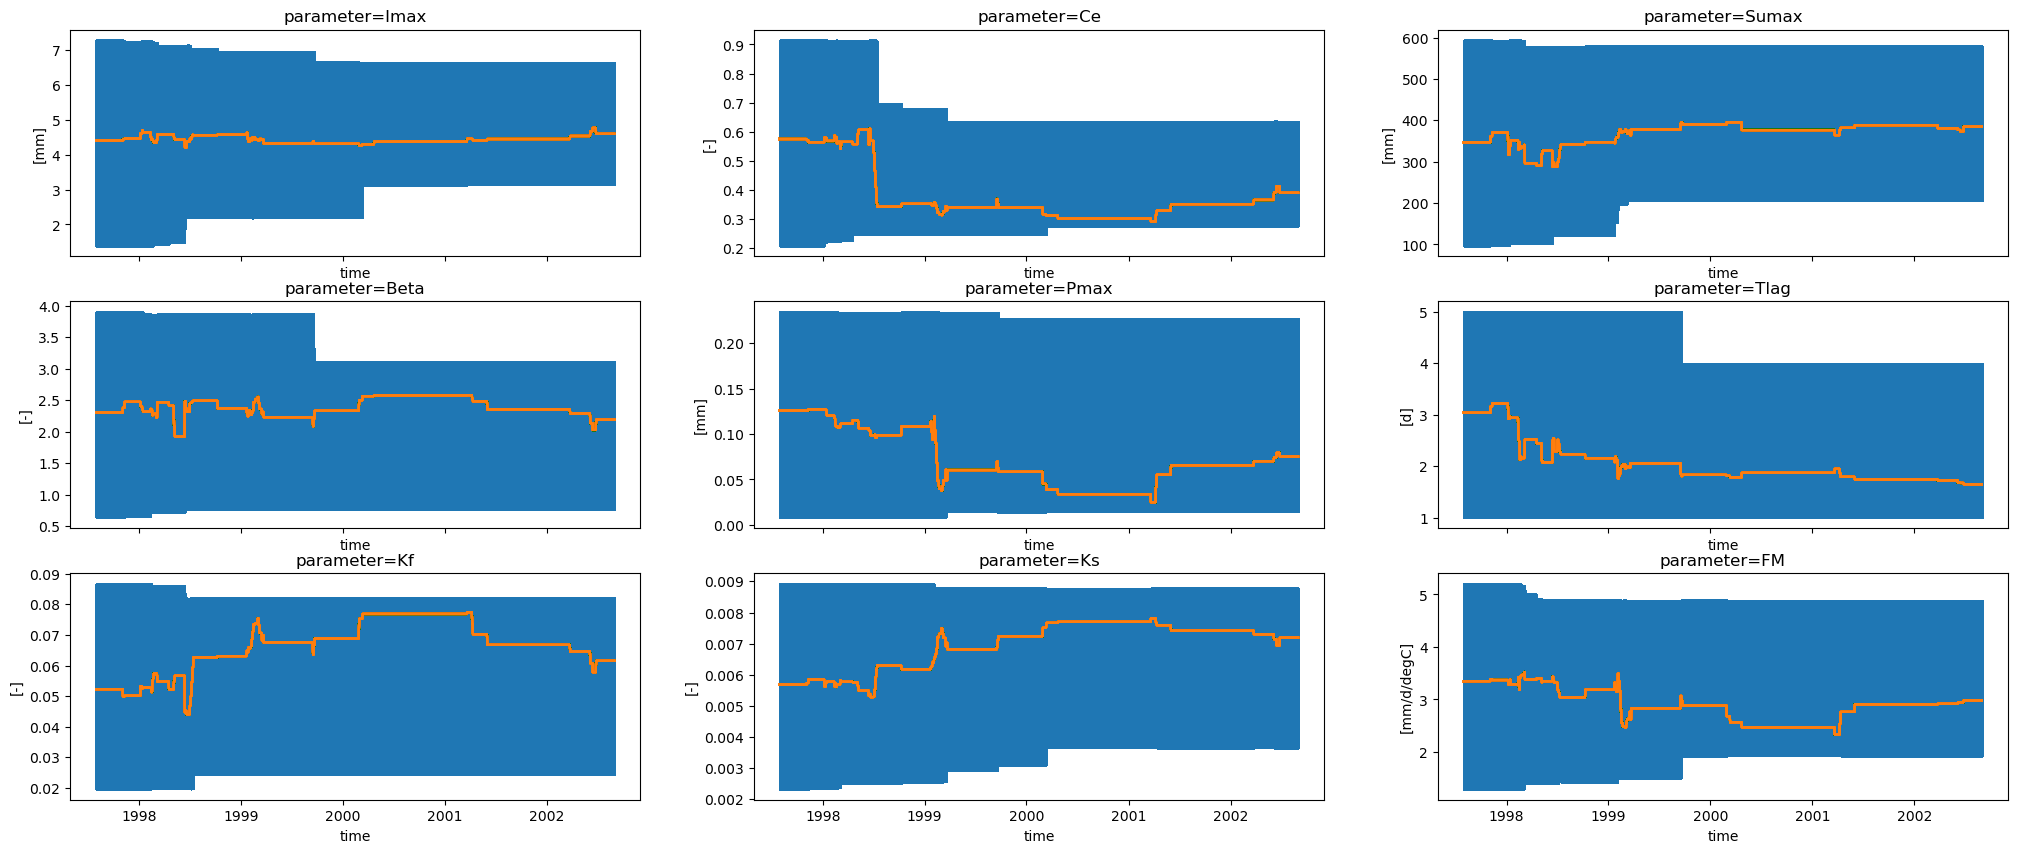

In [79]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

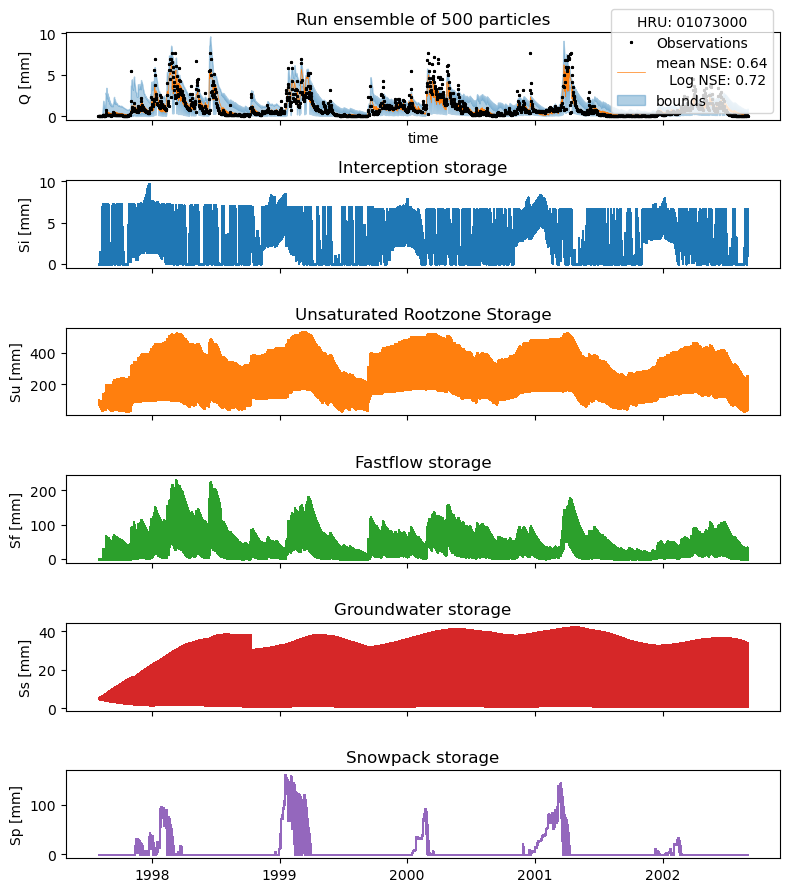

In [80]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

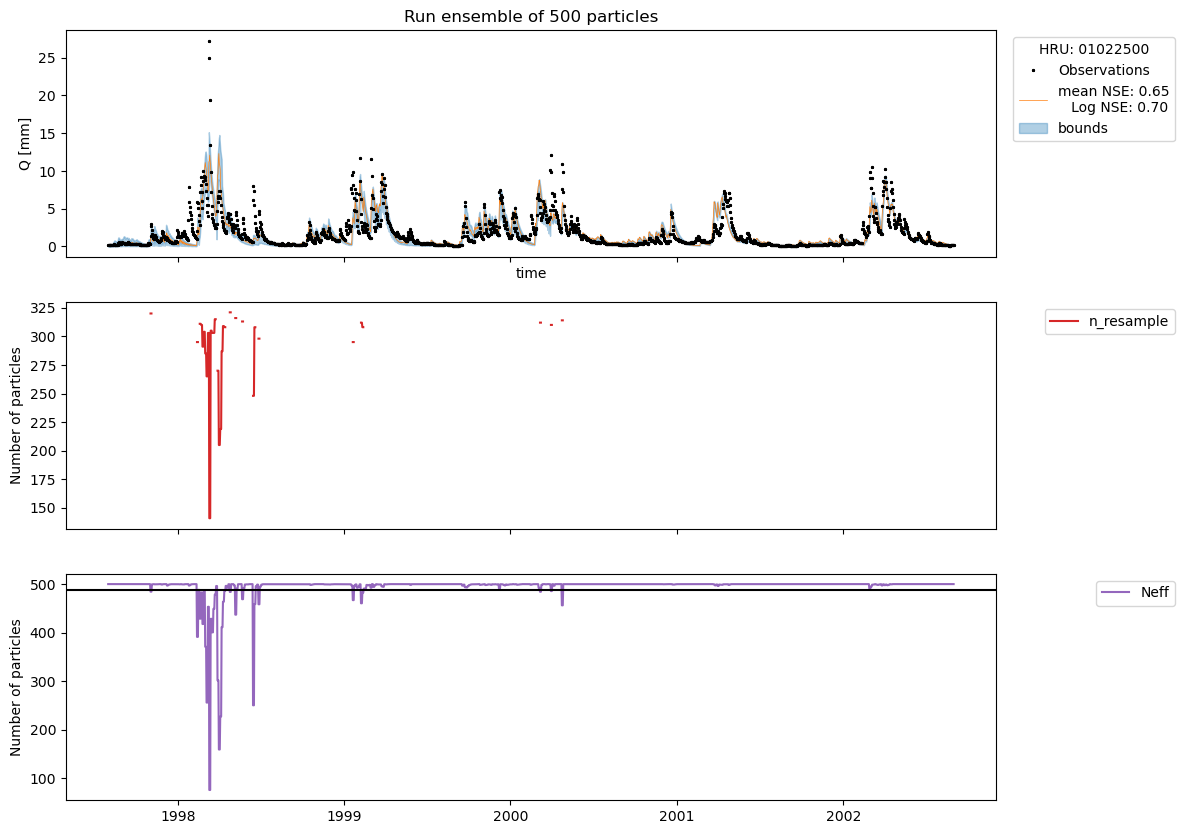

In [88]:
fig, ax = plt.subplots(3,1, figsize=(12,10),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.2,1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend(bbox_to_anchor=(1.2,1))
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

# another

In [82]:
i = sorted_iter.index( '01022500_2_1e-03')
ds_combined = lst_ds[i]
ds_combined

<xarray.Dataset> Size: 728kB
Dimensions:       (summary_stat: 3, time: 1857)
Coordinates:
  * summary_stat  (summary_stat) <U4 48B 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 15kB 1997-08-01 ... 2002-08-31
Data variables: (12/18)
    Imax          (summary_stat, time) float64 45kB ...
    Ce            (summary_stat, time) float64 45kB ...
    Sumax         (summary_stat, time) float64 45kB ...
    Beta          (summary_stat, time) float64 45kB ...
    Pmax          (summary_stat, time) float64 45kB ...
    Tlag          (summary_stat, time) float64 45kB ...
    ...            ...
    Ss            (summary_stat, time) float64 45kB ...
    Sp            (summary_stat, time) float64 45kB ...
    Q             (summary_stat, time) float64 45kB ...
    Q_obs         (time) float64 15kB 0.254 0.2456 0.2498 ... 0.154 0.1499
    Neff          (time) float64 15kB ...
    n_resample    (time) float64 15kB ...
Attributes: (12/13)
    title:              HBV storage & parameter terms data over time for 500 ...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0
    sigma_ps:           0
    sigma_w:            2
    sigma_p_Sf:         0.001
    ...                 ...
    n_particles:        500
    HRU_id:             01022500
    p_min_initial:      [1.12182327e+00 3.22232898e-01 1.13079965e+02 1.37713...
    p_max_initial:      [3.20383033e+00 6.15753470e-01 3.05794566e+02 3.21596...
    s_max_initial:      [  2.55532786 167.43273213  42.05499716  32.14507687 ...
    s_min_initial:      [ 0.73914092 62.34886481 17.85686147 12.90167866 39.0...

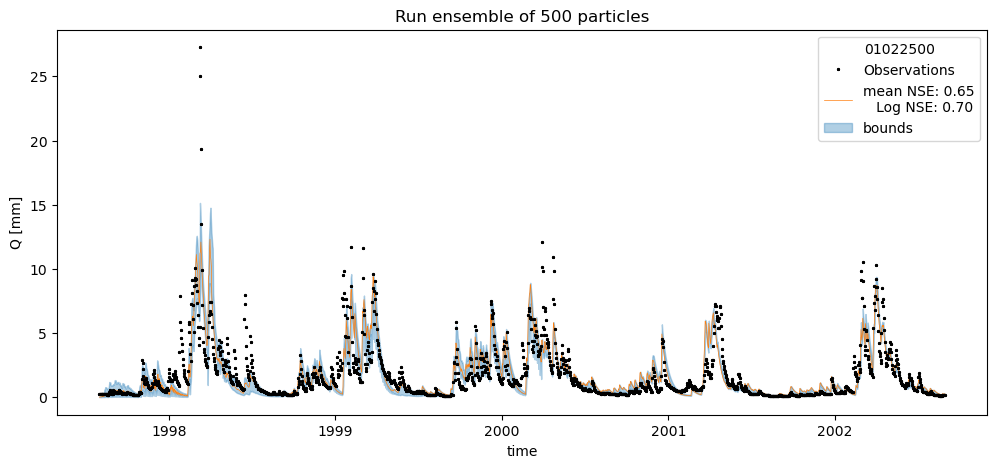

In [87]:
fig, ax = plt.subplots(1,1, figsize=(12,5),sharex=True)
ax = plot_hydrograph(ds_combined, ax)
ax.legend(title=ds_combined.attrs['HRU_id'])
current_time = str(datetime.now())[:-10].replace(":","_")
# fig.savefig(figure_path / f"Ensemble run for {ds_combined.attrs['HRU_id']}_{ds_combined.attrs['n_particles']}_{current_time}.png",bbox_inches="tight", dpi=600)

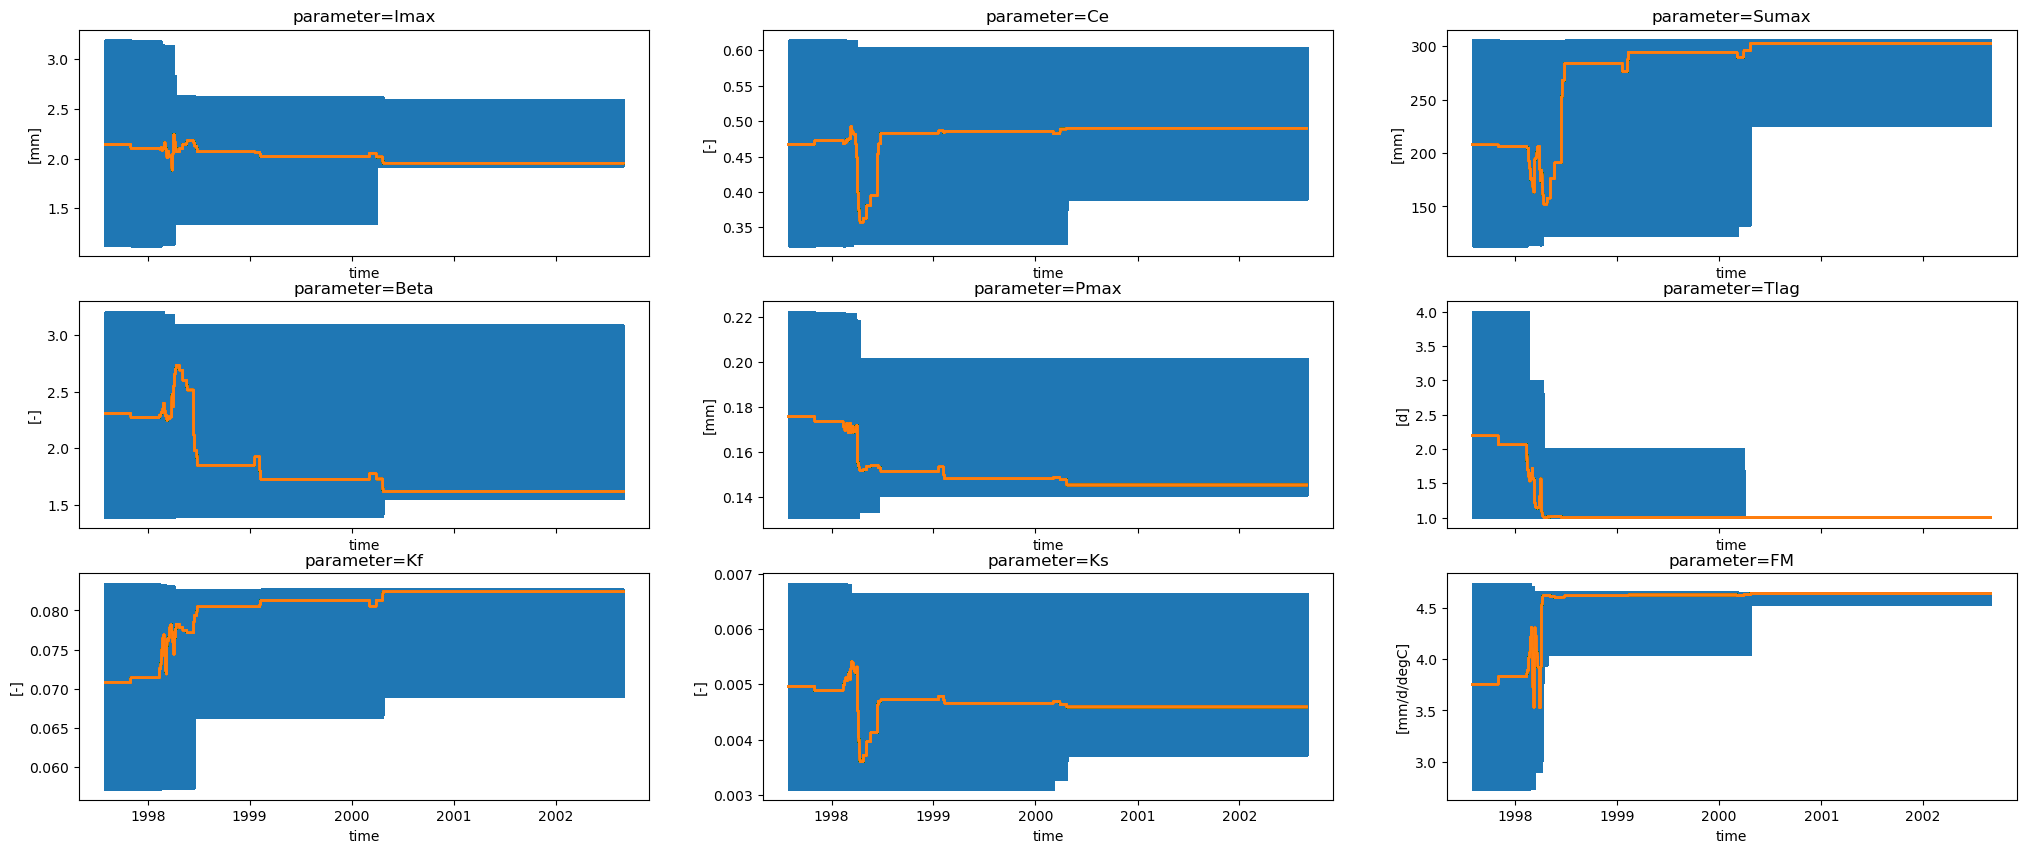

In [84]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

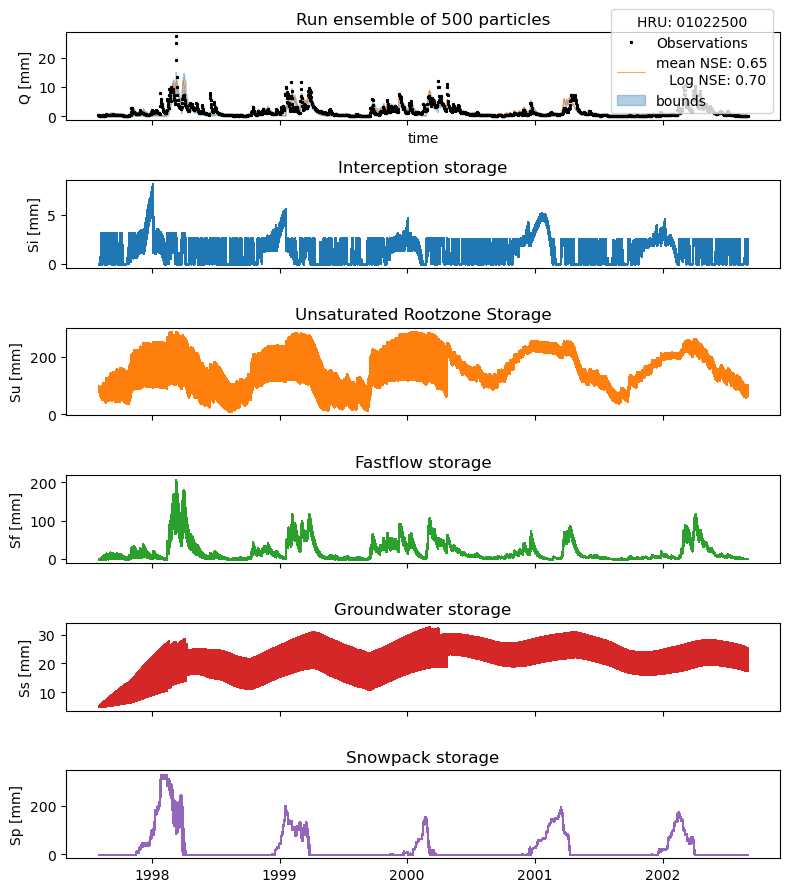

In [85]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

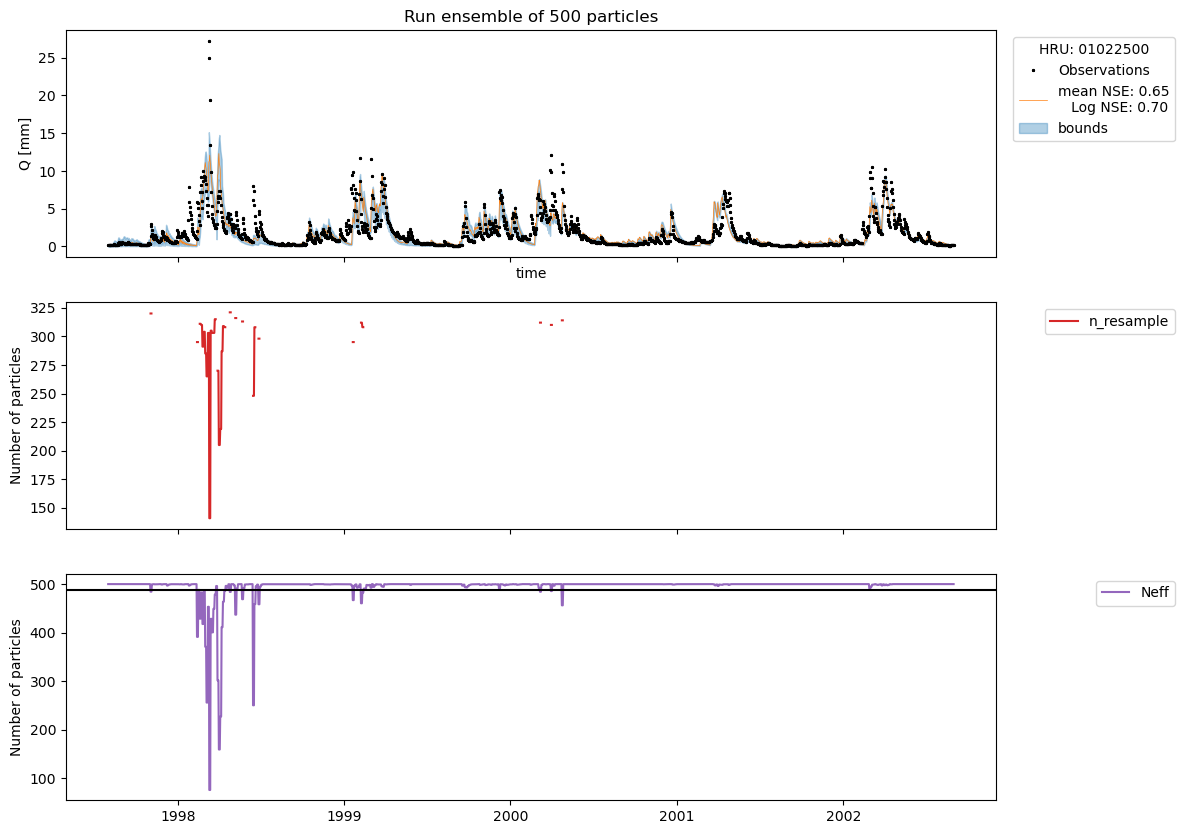

In [86]:
fig, ax = plt.subplots(3,1, figsize=(12,10),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.2,1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend(bbox_to_anchor=(1.2,1))
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

In [128]:
param_arr = np.zeros((len(lst_ds),2,len(param_names)))
stor_arr = np.zeros((len(lst_ds),2,len(stor_names)))
         
for index, ds_combined in enumerate(lst_ds):
    param_arr[index,0] = ds_combined.attrs['p_min_initial'] 
    param_arr[index,1] = ds_combined.attrs['p_max_initial']
    stor_arr[index,0] = ds_combined.attrs['s_min_initial'] 
    stor_arr[index,1] = ds_combined.attrs['s_max_initial']

In [129]:
param_names_no_su = param_names[:2] + param_names[3:]
param_names_no_su

['Imax', 'Ce', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

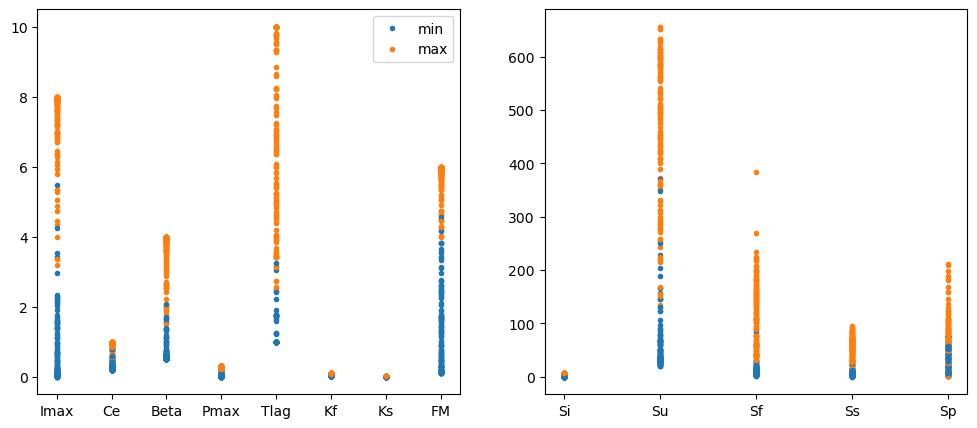

In [130]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
for arr in param_arr:
    arr_no_su_0 = list(arr[0][:2]) + list(arr[0][3:])
    ax[0].plot(param_names_no_su, arr_no_su_0, color="C0",label="min",marker='.',lw=0)
    arr_no_su_1 = list(arr[1][:2]) + list(arr[1][3:])
    ax[0].plot(param_names_no_su, arr_no_su_1, color="C1",label="max",marker='.',lw=0)

handels, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handels[:2], labels[:2])
for arr in stor_arr:
    ax[1].plot(stor_names, arr[0], color="C0",marker='.',lw=0)
    ax[1].plot(stor_names, arr[1], color="C1",marker='.',lw=0)